In [1]:
import gurobipy as gp
from gurobipy import GRB
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Corrected import
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool  # For pooling in the decoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt  # For plotting losses

In [2]:
torch.set_printoptions(precision=4, sci_mode=False)

In [3]:
from parse_QP import my_callback, parse_qplib_file

In [4]:
# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

# Solution storage
grb_model._feasible_solutions = []
grb_model._relaxation_solutions = []
grb_model.setParam("MIPGap", 0.05)

# Optimize
grb_model.optimize(my_callback)

Restricted license - for non-production use only - expires 2026-11-23
Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 9124 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 64 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.05

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x00d24133
Model has 464 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3654.4800000
Presolve time: 0.00s
Presolved: 901 rows, 526 columns, 2321 nonzeros
Pres

In [5]:
# Retrieve optimal solution if available
if grb_model.status == GRB.OPTIMAL:
    optimal_solution = grb_model.getAttr('X', grb_model.getVars())
    print("Optimal solution:", optimal_solution)
else:
    print(f"Model status: {grb_model.status}")

Optimal solution: [0.0, 0.0, 0.49055482068657474, 0.0, 0.0, 0.09207045008492966, 0.0, 0.0, 0.06558348815658188, 0.2063472207852159, 0.0, 0.14544402028669787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 1.0, 0.0, 0.0, 1.0, 1.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [6]:
# Define a maximum finite bound for replacing infinities
max_finite_bound = 1e5

# Extract bounds and handle infinities
variable_bounds = {}
for var in grb_model.getVars():
    lower_bound = var.LB
    upper_bound = var.UB
    
    # Replace infinite bounds with finite values
    if lower_bound == float('-inf'):
        lower_bound = -max_finite_bound
    if upper_bound == float('inf'):
        upper_bound = max_finite_bound
    
    variable_bounds[var.VarName] = {'Lower': lower_bound, 'Upper': upper_bound}

In [7]:
data = parse_qplib_file('0031')
A, b_vector, E, d_vector, Q = data['A'], data['b_vector'], data['E'], data['d'], data['Q']
variables_info = [v[0] for v in data['variables_info']]
binary_indices, variable_indices = data['binary_indices'], data['variable_indices']
m, n = A.shape
row_indices, col_indices = np.nonzero(A); edge_weights = A[row_indices, col_indices]
variable_types = np.array([0 if v[0] == 'x' else 1 for v in variables_info])
continuous_indices, binary_indices = np.where(variable_types == 0)[0], np.where(variable_types == 1)[0]
n_continuous, n_binary, n_variables = len(continuous_indices), len(binary_indices), len(continuous_indices)+len(binary_indices)
variable_types_tensor = torch.tensor(variable_types)
variable_lower_bounds = torch.tensor([variable_bounds[var_name]['Lower'] for var_name in variable_bounds], dtype=torch.float)
variable_upper_bounds = torch.tensor([variable_bounds[var_name]['Upper'] for var_name in variable_bounds], dtype=torch.float)
for i, vtype in enumerate(variable_types_tensor):
    if vtype == 1.0: variable_lower_bounds[i], variable_upper_bounds[i] = 0.0, 1.0

In [8]:
binary_indices

array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [9]:
from generate_solutions import load_or_generate_solutions, generate_feasible_solutions, generate_infeasible_solutions, generate_infeasible_nonintegral_solutions

num_samples = 1000

feasible_solutions, feasible_costs, \
infeasible_solutions, infeasible_costs, \
infeasible_nonintegral_solutions, infeasible_nonintegral_costs = load_or_generate_solutions(
    generate_new=False,
    feasible_data_file='feasible_data.pkl',
    infeasible_data_file='infeasible_data.pkl',
    infeasible_nonintegral_data_file='infeasible_nonintegral_data.pkl',
    A=A, E=E, Q=Q, variables_info=variables_info, b_vector=b_vector, d_vector=d_vector,
    generate_feasible_solutions=generate_feasible_solutions,  
    generate_infeasible_solutions=generate_infeasible_solutions,
    generate_infeasible_nonintegral_solutions=generate_infeasible_nonintegral_solutions,
    num_solutions = num_samples
)


Loaded existing feasible solutions from file.
Loaded existing infeasible solutions from file.
Loaded existing infeasible non-integral solutions from file.


In [29]:
import torch
import torch.nn as nn
from train_eval import train, test
from data_preparation import prepare_data
from networks import JointGNN

batch_size = 128
device = 'cuda'
train_loader, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    feasible_solutions, feasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=batch_size, device=device
)

model = JointGNN(hidden_channels_obj=128, hidden_channels_cons=128, decoder_hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

criterion_mse = nn.MSELoss()
criterion_bce = nn.BCELoss()

num_epochs = 100
beta = 1e-3  # Weight for the KLD loss

# Evaluate before training
initial_test_results = test(test_loader, model, criterion_mse, criterion_bce, device=device, beta=beta)
print("Before training, Test Total Loss:", initial_test_results[0],
      "Recon Loss:", initial_test_results[1],
      "Cost Loss:", initial_test_results[2],
      "Constraint Loss:", initial_test_results[3],
      "Integrality Loss:", initial_test_results[4],
      "KLD Loss:", initial_test_results[5])

# Initialize lists to store losses
train_total_losses = []
train_recon_losses = []
train_cost_losses = []
train_constraint_losses = []
train_integrality_losses = []
train_kld_losses = []

test_total_losses = [initial_test_results[0]]
test_recon_losses = [initial_test_results[1]]
test_cost_losses = [initial_test_results[2]]
test_constraint_losses = [initial_test_results[3]]
test_integrality_losses = [initial_test_results[4]]
test_kld_losses = [initial_test_results[5]]

# Variable to track the best training loss
best_train_loss = float('inf')
best_model_path = 'best_model_by_train_loss.pth'

for epoch in range(1, num_epochs + 1):
    train_results = train(train_loader, model, optimizer, criterion_mse, criterion_bce, device=device, beta=beta)
    test_results = test(test_loader, model, criterion_mse, criterion_bce, device=device, beta=beta)

    # Unpack train results
    tr_total, tr_recon, tr_cost, tr_const, tr_int, tr_kld = train_results
    # Unpack test results
    te_total, te_recon, te_cost, te_const, te_int, te_kld = test_results

    # Store training losses
    train_total_losses.append(tr_total)
    train_recon_losses.append(tr_recon)
    train_cost_losses.append(tr_cost)
    train_constraint_losses.append(tr_const)
    train_integrality_losses.append(tr_int)
    train_kld_losses.append(tr_kld)

    # Store testing losses
    test_total_losses.append(te_total)
    test_recon_losses.append(te_recon)
    test_cost_losses.append(te_cost)
    test_constraint_losses.append(te_const)
    test_integrality_losses.append(te_int)
    test_kld_losses.append(te_kld)

    # Check if this is the best training loss so far
    if tr_total < best_train_loss:
        best_train_loss = tr_total
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch}: New best training loss: {best_train_loss:.4f}. Model saved.")

    if epoch % 5 == 0:
        print(f"Epoch {epoch}:")
        print(f"  Train Loss: {tr_total:.4f}, Recon: {tr_recon:.4f}, Cost: {tr_cost:.4f}, Const: {tr_const:.4f}, Int: {tr_int:.4f}, KLD: {tr_kld:.4f}")
        print(f"  Test Loss:  {te_total:.4f}, Recon: {te_recon:.4f}, Cost: {te_cost:.4f}, Const: {te_const:.4f}, Int: {te_int:.4f}, KLD: {te_kld:.4f}")

# After training, if you want to ensure you are using the best model:
model.load_state_dict(torch.load(best_model_path))
model.eval()
print("Loaded the best model by training loss for further evaluation.")


Before training, Test Total Loss: 6.641303430942815 Recon Loss: 0.24705752738366613 Cost Loss: 1.0318786247045282 Constraint Loss: 4.6496374961088724 Integrality Loss: 0.7127265712656148 KLD Loss: 0.0031050447926878237
Epoch 1: New best training loss: 1.8834. Model saved.
Epoch 2: New best training loss: 0.2268. Model saved.
Epoch 3: New best training loss: 0.0916. Model saved.
Epoch 4: New best training loss: 0.0637. Model saved.
Epoch 5: New best training loss: 0.0524. Model saved.
Epoch 5:
  Train Loss: 0.0524, Recon: 0.0007, Cost: 0.0048, Const: 0.0022, Int: 0.0429, KLD: 1.8373
  Test Loss:  0.0459, Recon: 0.0003, Cost: 0.0035, Const: 0.0014, Int: 0.0388, KLD: 1.9337
Epoch 6: New best training loss: 0.0453. Model saved.
Epoch 9: New best training loss: 0.0325. Model saved.
Epoch 10: New best training loss: 0.0302. Model saved.
Epoch 10:
  Train Loss: 0.0302, Recon: 0.0001, Cost: 0.0015, Const: 0.0007, Int: 0.0255, KLD: 2.3485
  Test Loss:  0.0298, Recon: 0.0001, Cost: 0.0013, Const

/tmp/ipykernel_514/1309965856.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


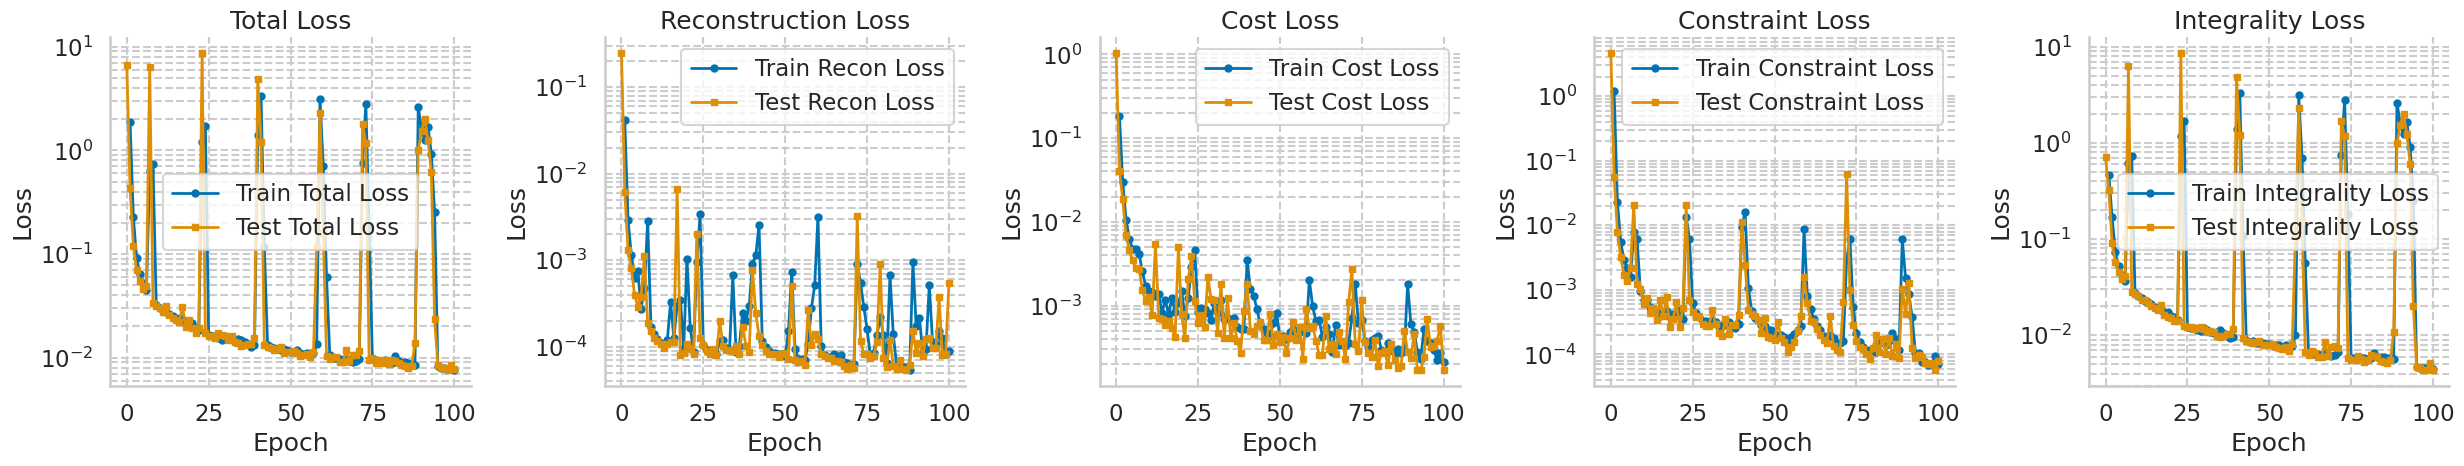

In [30]:
# from plotting import plot_losses
import seaborn as sns

plot_losses(
    num_epochs,
     train_total_losses, train_recon_losses, train_cost_losses, train_constraint_losses, train_integrality_losses,
     test_total_losses, test_recon_losses, test_cost_losses, test_constraint_losses, test_integrality_losses
)

In [21]:
# from plotting import plot_predictions_vs_actuals

# model.eval()


# plot_predictions_vs_actuals(model, test_loader, device=device, num_samples_to_show=1000)

In [103]:
train_loader, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    feasible_solutions, feasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=1, device=device
)

# data_obj_batch, data_feas_batch = next(iter(test_loader))
# data_obj_batch = data_obj_batch.to(device)
# data_feas_batch = data_feas_batch.to(device)

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
import numpy as np

###############################
# Compute Latent Mean and Std #
###############################

train_loader, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    feasible_solutions, feasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=1, device=device
)

def compute_latent_statistics(model, train_loader, device='cuda'):
    model.eval()
    all_z_mu = []

    with torch.no_grad():
        for data_obj_batch, data_feas_batch in train_loader:
            data_obj_batch = data_obj_batch.to(device)
            data_feas_batch = data_feas_batch.to(device)

            # Forward pass to get z_mu, z_logvar
            # model returns: x_hat, predicted_cost, predicted_constraints, predicted_integrality, z_mu, z_logvar
            _, _, _, _, z_mu, z_logvar = model(data_obj_batch, data_feas_batch)
            # z_mu shape: (num_nodes_total, concat_dim) for each problem instance's graph
            # If the loader batches multiple graphs, verify shapes and store them appropriately.
            
            # If batching multiple graphs, z_mu will contain all nodes from those graphs stacked.
            # Just append them to list
            all_z_mu.append(z_mu.cpu().numpy())

    # Concatenate all collected z_mu
    all_z_mu = np.concatenate(all_z_mu, axis=0)  # shape: (Total_nodes_across_dataset, concat_dim)
    
    latent_mean_np = np.mean(all_z_mu, axis=0)  # shape: (concat_dim,)
    latent_std_np = np.std(all_z_mu, axis=0)    # shape: (concat_dim,)

    # Now, we must consider that z_mu is (num_nodes_total, concat_dim) per instance.
    # If num_nodes_total is consistent (e.g., fixed size problem), we can reshape accordingly.
    # Suppose each problem instance always has the same number of total nodes: num_nodes_total.
    # If not given, we should know it from the problem setup:
    # For example:
    #   num_nodes_total = number_of_variable_nodes + number_of_constraint_nodes from your instance.
    # We can get this from a single forward pass on one data_obj_batch, data_feas_batch pair.

    # Let's assume we've done one forward pass on test_loader to get these shapes:
    # data_obj_batch, data_feas_batch = next(iter(test_loader))
    # data_obj_batch, data_feas_batch = data_obj_batch.to(device), data_feas_batch.to(device)
    # _, _, _, _, z_mu_example, _ = model(data_obj_batch, data_feas_batch)
    # num_nodes_total, concat_dim = z_mu_example.shape

    # For demonstration, let's assume we already know these from a previous step:
    # (We'll just infer them from the first batch of the test loader)
    data_obj_batch, data_feas_batch = next(iter(test_loader))
    data_obj_batch = data_obj_batch.to(device)
    data_feas_batch = data_feas_batch.to(device)
    with torch.no_grad():
        _, _, _, _, z_mu_example, _ = model(data_obj_batch, data_feas_batch)
    num_nodes_total, concat_dim = z_mu_example.shape

    # The computed latent_mean_np and latent_std_np are per dimension, but do not reflect node structure.
    # We assume uniform distribution of nodes and that we treat all nodes together.
    # If all nodes share the same latent dimensions (which they do), we can replicate:
    # We'll create latent_mean and latent_std of shape (num_nodes_total, concat_dim),
    # assuming a node-level structure. Typically, the statistics are computed over all nodes equally.
    # We'll just tile them:
    latent_mean_np_full = np.tile(latent_mean_np, (num_nodes_total, 1))
    latent_std_np_full = np.tile(latent_std_np, (num_nodes_total, 1))

    latent_mean = torch.tensor(latent_mean_np_full, dtype=torch.float)
    latent_std = torch.tensor(latent_std_np_full, dtype=torch.float)

    return latent_mean, latent_std, num_nodes_total, concat_dim


#############################
# Latent Optimization Code  #
#############################

def optimize_single_z(
    model,
    data_obj,
    data_feas,
    latent_mean,
    latent_std,
    device='cuda',
    lr=0.001,
    num_iterations=200,
    penalty_weight=1e-3,
    penalty_epsilon=1e-8,
    penalty_weight_constraints=10.0
):
    model.eval()
    data_obj = data_obj.to(device)
    data_feas = data_feas.to(device)
    latent_mean = latent_mean.to(device)
    latent_std = latent_std.to(device)

    with torch.no_grad():
        _, _, _, _, z_mu, z_logvar = model(data_obj, data_feas)

    variable_mask = data_feas.variable_mask
    num_var_nodes = variable_mask.sum().item()

    z_init = z_mu.detach().clone().requires_grad_(True)
    optimizer = torch.optim.Adam([z_init], lr=lr)
    batch = data_feas.batch[data_feas.variable_mask]

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        z_var = z_init[:num_var_nodes, :]
        z_constraints = z_init[num_var_nodes:, :]

        z_var_pooled = global_mean_pool(z_var, batch)
        predicted_cost = model.decoder_cost(z_var_pooled).squeeze()

        z_constraints_flat = z_constraints.reshape(-1, z_constraints.size(-1))
        predicted_constraints = model.decoder_constraints(z_constraints_flat).squeeze()

        # Ensure cost is scalar
        if predicted_cost.dim() > 0:
            predicted_cost = predicted_cost.mean()

        # For constraints:
        if predicted_constraints.dim() > 0:
            constraints_mean = predicted_constraints.mean()
        else:
            constraints_mean = predicted_constraints

        constraints_viol = constraints_mean

        # Make sure this is scalar as well
        # constraints_viol is scalar after mean, so it's fine
        if constraints_viol.dim() > 0:
            constraints_viol = constraints_viol.mean()

        obj = predicted_cost + penalty_weight_constraints * constraints_viol

        diff = z_init - latent_mean
        scaled_diff = diff**2 / (latent_std**2 + penalty_epsilon)
        reg_loss = scaled_diff.mean()

        total_loss = obj + penalty_weight * reg_loss
        total_loss.backward()
        optimizer.step()

        if iteration % 50 == 0:
            print(f"Iteration {iteration}/{num_iterations}: "
                  f"Obj={obj.item():.4f}, Cost={predicted_cost.item():.4f}, "
                  f"ConstViol={constraints_viol.item():.4f}, Reg={reg_loss.item():.4f}")

    z_var_final = z_init[:num_var_nodes, :]
    x_hat_final = model.decoder_x(z_var_final).squeeze()

    return z_init.detach(), x_hat_final.detach()


##########################
# Putting It All Together
##########################

# Assuming you have model, Q, A, E, n_variables, feasible_solutions, etc. defined
# and you already ran prepare_data(...) as per your snippet:

# mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints
# are from your prepare_data call, which you have done.

# Compute latent statistics
latent_mean, latent_std, num_nodes_total, concat_dim = compute_latent_statistics(model, train_loader, device=device)

train_loader, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    feasible_solutions, feasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=1, device=device
)

# Get a data batch from test_loader (or whichever instance you want to optimize)
data_obj_batch, data_feas_batch = next(iter(test_loader))
data_obj_batch = data_obj_batch.to(device)
data_feas_batch = data_feas_batch.to(device)

# Perform latent optimization on this instance
z_opt, x_opt = optimize_single_z(model, data_obj_batch, data_feas_batch, latent_mean, latent_std, device=device)

print("Optimized latent code:", z_opt)
print("Decoded solution x_opt:", x_opt)


Iteration 0/200: Obj=9.6543, Cost=1.6106, ConstViol=0.8044, Reg=1.8961
Iteration 50/200: Obj=8.9190, Cost=1.3320, ConstViol=0.7587, Reg=1.8800
Iteration 100/200: Obj=8.1885, Cost=1.0605, ConstViol=0.7128, Reg=1.8695
Iteration 150/200: Obj=7.4542, Cost=0.7871, ConstViol=0.6667, Reg=1.8633
Optimized latent code: tensor([[ 1.8747,  1.0027, -2.0436,  ..., -3.1108, -2.4907,  0.1025],
        [ 0.5156,  2.0221, -1.1667,  ..., -1.2228, -1.4234,  0.2191],
        [ 0.9048,  2.0281, -1.3411,  ..., -1.5981, -1.6869,  0.0973],
        ...,
        [-0.6060,  0.3767,  0.0412,  ...,  0.2369,  0.0068, -0.7291],
        [-0.9262, -0.6731, -0.2881,  ..., -0.2301, -0.3811, -0.2819],
        [ 0.0122, -4.0385, -1.9701,  ..., -1.7196, -0.8265,  4.6169]],
       device='cuda:0')
Decoded solution x_opt: tensor([0.8821, 0.3053, 0.4030, 0.4214, 0.6160, 0.2258, 0.8589, 0.6101, 0.3123,
        0.1507, 0.2957, 0.6906, 0.7767, 0.9888, 0.4421, 0.5490, 0.7246, 0.7364,
        0.6618, 0.9806, 0.9451, 0.5221, 0.9507

In [107]:
# Perform latent optimization on this instance
z_opt, x_opt = optimize_single_z(model, data_obj_batch, data_feas_batch, latent_mean, latent_std, device=device, num_iterations=1000,)

print("Optimized latent code:", z_opt)
print("Decoded solution x_opt:", x_opt)

Iteration 0/1000: Obj=9.6543, Cost=1.6106, ConstViol=0.8044, Reg=1.8961
Iteration 50/1000: Obj=8.9190, Cost=1.3320, ConstViol=0.7587, Reg=1.8800
Iteration 100/1000: Obj=8.1885, Cost=1.0605, ConstViol=0.7128, Reg=1.8695
Iteration 150/1000: Obj=7.4542, Cost=0.7871, ConstViol=0.6667, Reg=1.8633
Iteration 200/1000: Obj=6.7133, Cost=0.5166, ConstViol=0.6197, Reg=1.8615
Iteration 250/1000: Obj=5.9850, Cost=0.2564, ConstViol=0.5729, Reg=1.8671
Iteration 300/1000: Obj=5.2558, Cost=-0.0015, ConstViol=0.5257, Reg=1.8761
Iteration 350/1000: Obj=4.5287, Cost=-0.2590, ConstViol=0.4788, Reg=1.8892
Iteration 400/1000: Obj=3.7923, Cost=-0.5290, ConstViol=0.4321, Reg=1.9067
Iteration 450/1000: Obj=3.0605, Cost=-0.7954, ConstViol=0.3856, Reg=1.9263
Iteration 500/1000: Obj=2.3527, Cost=-1.0359, ConstViol=0.3389, Reg=1.9489
Iteration 550/1000: Obj=1.5172, Cost=-1.2752, ConstViol=0.2792, Reg=1.9771
Iteration 600/1000: Obj=0.2005, Cost=-1.5068, ConstViol=0.1707, Reg=2.0111
Iteration 650/1000: Obj=-0.9995, C

In [109]:
x_opt[:30]

tensor([1.2329, 0.6610, 0.7612, 0.7800, 0.9801, 0.5760, 1.2141, 0.9740, 0.6682,
        0.4755, 0.6512, 1.0563, 1.1420, 1.3214, 0.8010, 0.9096, 1.0900, 1.0964,
        1.0217, 1.3463, 1.3101, 0.8810, 1.3158, 1.0555, 0.7059, 0.8091, 1.0589,
        1.2257, 1.4012, 1.3999], device='cuda:0')

In [108]:
logvar

tensor([[-5.8992, -1.8695, -0.5911,  ..., -8.5321, -5.0728, -5.4119],
        [-4.7316, -0.7223, -1.1982,  ..., -6.5015, -3.8012, -4.5845],
        [-4.8055, -1.0911, -1.3637,  ..., -7.0217, -4.1632, -4.6996],
        ...,
        [-0.1438, -6.2968,  0.1599,  ..., -5.9809, -0.0162,  0.0217],
        [-0.1541, -6.8659,  0.1652,  ..., -6.3259, -0.1913, -0.0543],
        [-5.7308, -7.0316, -6.1148,  ..., -7.0643, -3.9435, -7.6668]],
       device='cuda:0')

In [101]:
x_opt.shape

torch.Size([7680])

In [100]:
# Suppose x_star is obtained from Dec(z_opt, model)
# Ensure x_star is on CPU for simplicity:
x_star = x_opt.detach().cpu().numpy()[:60]

tolerance = 1e-6

# Check inequalities: A x_star <= b
Ax = A @ x_star
feasible_ineq = np.all(Ax <= b_vector + tolerance)

# Check equalities: E x_star = d
Ex = E @ x_star
feasible_eq = np.all(np.abs(Ex - d_vector) <= tolerance)

if feasible_ineq and feasible_eq:
    print("Solution is feasible.")
else:
    print("Solution is not feasible.")
    if not feasible_ineq:
        violated_amount = (Ax - b_vector)[Ax > b_vector + tolerance]
        print("Inequality constraints violated. Violations:", violated_amount)
    if not feasible_eq:
        eq_violations = (Ex - d_vector)[np.abs(Ex - d_vector) > tolerance]
        print("Equality constraints violated. Violations:", eq_violations)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7680 is different from 60)

In [81]:
test(test_loader, model, criterion_mse, criterion_bce, device=device)

(0.007797670510659171,
 0.0005474527542852532,
 0.00016559830403175331,
 7.654451705766958e-05,
 0.004338527917162197,
 2.669546815705001)

In [66]:
# Suppose x_star is obtained from Dec(z_opt, model)
# Ensure x_star is on CPU for simplicity:
x_star = x_star.detach().cpu().numpy()

tolerance = 1e-6

# Check inequalities: A x_star <= b
Ax = A @ x_star
feasible_ineq = np.all(Ax <= b_vector + tolerance)

# Check equalities: E x_star = d
Ex = E @ x_star
feasible_eq = np.all(np.abs(Ex - d_vector) <= tolerance)

if feasible_ineq and feasible_eq:
    print("Solution is feasible.")
else:
    print("Solution is not feasible.")
    if not feasible_ineq:
        violated_amount = (Ax - b_vector)[Ax > b_vector + tolerance]
        print("Inequality constraints violated. Violations:", violated_amount)
    if not feasible_eq:
        eq_violations = (Ex - d_vector)[np.abs(Ex - d_vector) > tolerance]
        print("Equality constraints violated. Violations:", eq_violations)


Solution is not feasible.
Inequality constraints violated. Violations: [1.14710846e+03 8.78677368e-01 3.08074951e-02 3.95233154e-01
 6.01749420e-01 9.81506348e-01 3.93985748e-01 8.39653015e-01
 2.50270844e-01 9.26727295e-01 2.50457764e-01 8.45645905e-01
 5.57151794e-01 7.01866150e-01 1.05907059e+00 2.63904572e-01]
Equality constraints violated. Violations: [1156.12364578]


In [ ]:
Q = torch.tensor(Q, device = 'cuda:0', dtype = x_star.dtype)
x_star.T @ Q @ x_star

In [ ]:
x_star

In [ ]:
optimal_solution = torch.tensor(optimal_solution, device = 'cuda:0', dtype = x_star.dtype)

optimal_solution.T@Q@optimal_solution